<a href="https://colab.research.google.com/github/silvesray/nlp_projects/blob/main/Twitter_and_Reddit_Sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
from zipfile import ZipFile
import glob
import warnings
import subprocess

In [2]:
# ======================================================= DEFINITION DES CONSTANTES =============================================================
FOLDER_DRIVE = "drive/MyDrive/"
FOLDER_EXTRACT = "TWITTER_FOLDER"
EXTENSION = ".zip"
TEST_SIZE = 0.4
PATH_ZIP_FILE  =  list(filter(os.path.isfile, glob.glob(FOLDER_DRIVE + "*.zip")))
PATH_ZIP_FILE.sort(key=lambda x: os.path.getmtime(x))
NROWS = 6000

In [3]:
# ============================================================ CONFIGURATION DU NOTEBOOK =========================================================
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [4]:
def unzip_files(ext=".zip", folder=FOLDER_EXTRACT):
  zip_files = list(filter(os.path.isfile, glob.glob(f"{FOLDER_DRIVE}/*{ext}")))
  assert len(zip_files)>0, "Please the zip files didn't exist in current location"
  current_files = list(filter(lambda r : folder.lower().split("_")[0] in r , zip_files))
  if not os.path.isdir(folder):
    os.mkdir(folder)

  if len(os.listdir(f"{folder}"))==0:
    with ZipFile(current_files[-1], "r") as zip_ref:
      zip_ref.extractall(folder)

In [5]:
def csv_file_length(fname):
    process = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, error = process.communicate()
    if process.returncode != 0:
        raise IOError(error)
    return int(result.strip().split()[0])

# ======================================================================

unzip_files()
files_csv = list(filter(os.path.isfile, glob.glob(FOLDER_EXTRACT + "/*.csv"))) 

for fname in files_csv:
  random_rows_selection = csv_file_length(fname)
  print(f'Number of random rows in "{fname}" is:', random_rows_selection)

Number of random rows in "TWITTER_FOLDER/Reddit_Data.csv" is: 38306
Number of random rows in "TWITTER_FOLDER/Twitter_Data.csv" is: 192191


In [6]:
data = {}

for file in files_csv:
  name, ext = os.path.splitext(file)
  filename = os.path.basename(name).lower()
  nrows =  NROWS
  data[filename] = pd.read_csv(file, nrows=nrows, sep=",")

In [7]:
for key in data.keys():
  print("Data {} shape {}".format(key, data[key].shape))

Data reddit_data shape (6000, 2)
Data twitter_data shape (6000, 2)


In [8]:
twitter_data = data["twitter_data"]
reddit_data = data["reddit_data"]

<h2> Explanatory Data analysis </h2>


In [9]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  5999 non-null   object
 1   category    6000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 93.9+ KB


In [10]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  5990 non-null   object
 1   category       6000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 93.9+ KB


In [11]:
twitter_data.dropna(axis=0, how="any", inplace=True)
twitter_data.isnull().sum()

clean_text    0
category      0
dtype: int64

In [12]:
reddit_data.dropna(axis=0, how="any", inplace=True)
reddit_data.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [13]:
reddit_data.rename(columns={"clean_comment":"text"}, inplace=True)
twitter_data.rename(columns={"clean_text":"text"}, inplace=True)
pass

In [14]:
data = pd.concat([twitter_data, reddit_data])
data["category"] = data["category"].map({1.0:"positive", 0.0:"neutral", -1.0:"negative"})
data.reset_index(drop=True, inplace=True)

In [15]:
from sklearn.model_selection import train_test_split

seed = 42
train, test = train_test_split(data, test_size=TEST_SIZE, random_state=seed, stratify=data["category"])

Text(0.5, 1.0, 'Twitter data sentiment')

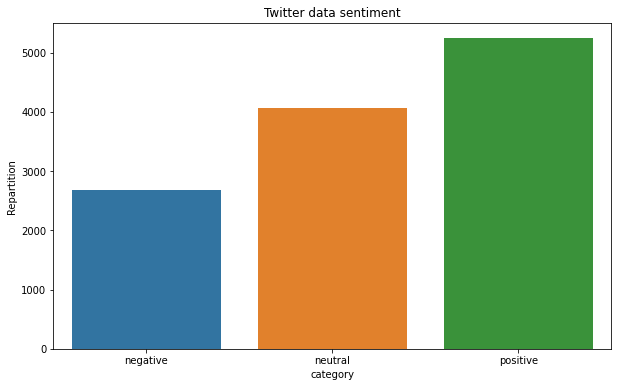

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
df = train.groupby(by="category")["text"].count()
labels = ["negative", "neutral", "positive"]
sns.countplot(x="category", data = data)
plt.ylabel("Repartition")
plt.title("Twitter data sentiment")

In [17]:
from plotly import graph_objs as go

In [18]:
temp = train.groupby('category').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

fig = go.Figure(go.Funnelarea(
    text =temp.category,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [19]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



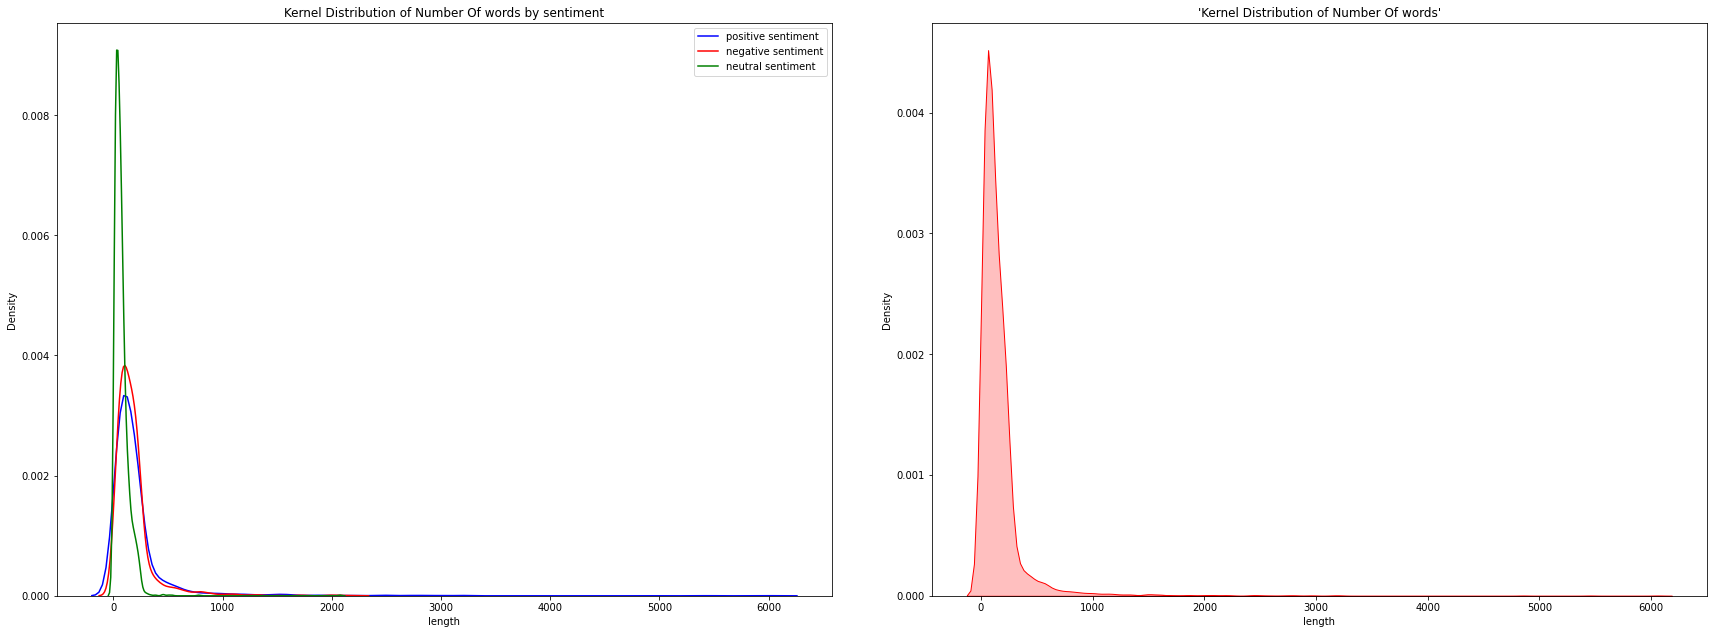

In [20]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(25, 10))
train["length"] = train["text"].apply(len)
sns.kdeplot(train[train['category']=='positive']['length'], color="b", label="positive sentiment", ax=ax0)
sns.kdeplot(train[train['category']=='negative']['length'], color="r", label="negative sentiment", ax=ax0)
sns.kdeplot(train[train['category']=='neutral']['length'], color="g", label="neutral sentiment", ax=ax0)
sns.kdeplot(train["length"], shade=True, color="r", ax=ax1)
ax1.set_title("'Kernel Distribution of Number Of words'")
ax0.set_title("Kernel Distribution of Number Of words by sentiment")
ax0.legend()
fig.tight_layout(pad=5.0)

In [21]:
from collections import Counter
from functools import reduce
from operator import add
from nltk.tokenize import TreebankWordTokenizer
import re

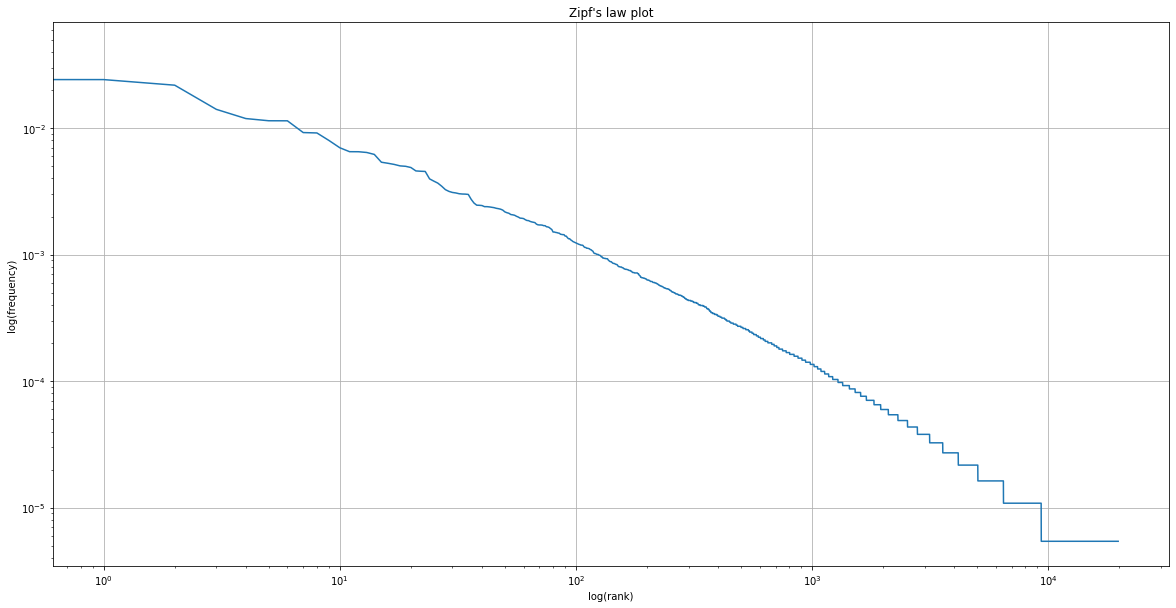

In [22]:
tok = TreebankWordTokenizer()
arr = train["text"].astype(str).drop_duplicates().apply(lambda x: tok.tokenize(x)).array

test = []
for i, token in enumerate(arr):
  test.extend(token)

c = Counter(test)
d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']
nb_total = d.occurences.sum()
d['freq'] = d.occurences.apply(lambda x: x/nb_total)
d = d.sort_values('freq', ascending=False)
plt.figure(figsize=(20,10))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)')
plt.title("Zipf's law plot")
x = list(range(d.shape[0]))
plt.plot(x, d.freq)

plt.show()

<h2> Repartition of integers, floats and percentage in textual data </h2>

In [23]:
pattern_ints = re.compile("[+-]?(?<![\d.])[0-9]+(?![\d.])")
pattern_floats = re.compile("[+-]?([0-9]*[.])?[0-9]+")
pattern_percentage = re.compile("[+-]?([0-9]*[.])?[0-9]+%")
pattern_year = re.compile("[12][0-9]{3}")

In [24]:
import re
df1 = train.drop_duplicates("text")
progs = [pattern_ints, pattern_floats, pattern_percentage, pattern_year]
nb_types = ['ints', 'floats', 'percents', 'years']
for prog, nb_type in zip(progs, nb_types):
  df1[nb_type] = df1['text'].apply(lambda x: len(prog.split(x))-1).array
df1[nb_types].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ints,floats,percents,years
3884,3,6,0,2
7063,0,0,0,0
5126,0,0,0,0
5057,0,0,0,0
11666,0,0,0,0


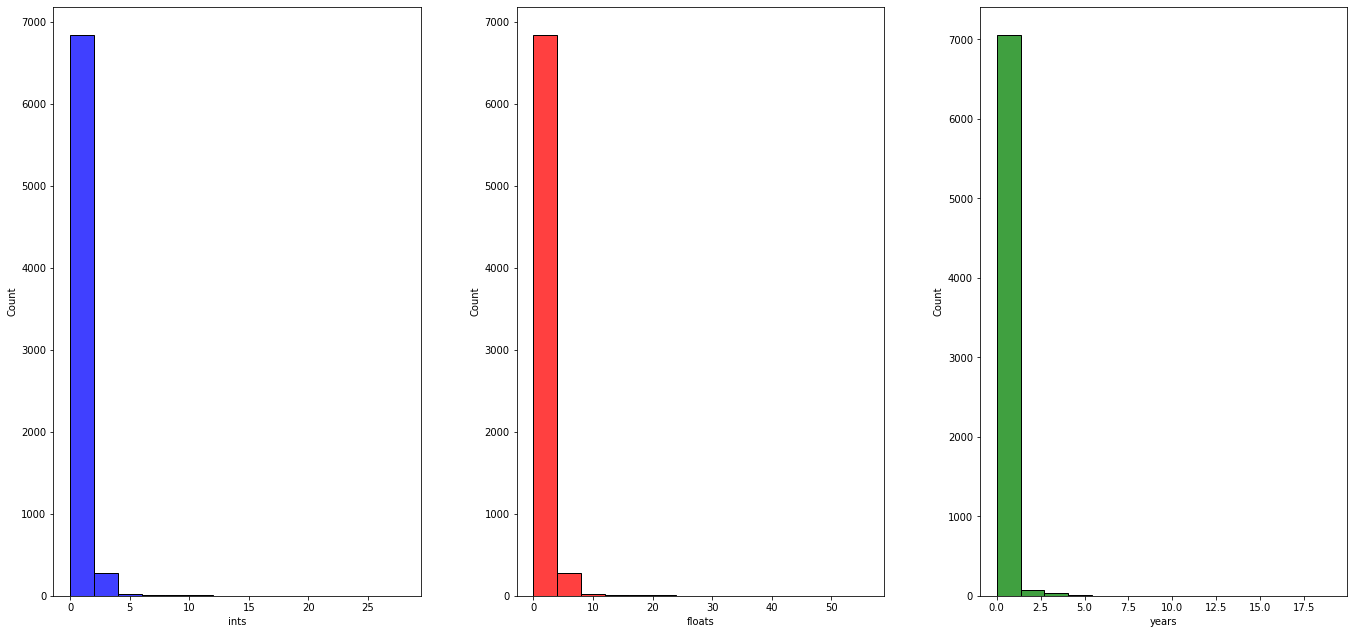

In [25]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(20, 10))
sns.histplot(df1["ints"], color="b", ax=ax0)
sns.histplot(df1["floats"], color="r", ax=ax1)
sns.histplot(df1["years"], color="g", ax=ax2)
fig.tight_layout(pad=5.0)

In [26]:
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def clean_text(text):
  text = str(text).lower()
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub("[’]", "'", text)
  text = re.sub("@\S+", ' ', text)
  text = re.sub("#\S+", ' ', text)
  text = re.sub("[']\w*", "",text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub("\s{2,}", ' ', text)
  text = text.strip()
  text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
  return text

In [28]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore",category=DeprecationWarning)
  train["cleaned_text"] = train["text"].apply(clean_text)
  train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn.manifold import TSNE
from IPython.display import HTML, display

In [30]:
X = train.loc[:, "text"]
cv = CountVectorizer() # max_features=300 reduces performances but is quite convenient for speed
X = cv.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20, max_iter=300, verbose=0).fit(X)

In [31]:
clusters = kmeans.predict(X)

print('Clusters:', clusters, 'of type', type(clusters))
print('Here is the occurrence counts for each cluster:')

for k, v in dict(Counter(clusters)).items():
  print('cluster', k, 'has', v, 'elements')

clusterTendancies = {'positive':list(), 'neutral': list(), 'negative': list()}

for sentiment, cluster in zip(train.loc[:, "category"], clusters):
  clusterTendancies[sentiment].append(cluster)

clusterTendancies = {k: Counter(v) for k, v in clusterTendancies.items()}
print('clusters distribution accross sentiments')
print(clusterTendancies)

print(train.loc[:,"text"].shape, 'hey', clusters.shape)

# Quantitative evaluation

label2id = {'positive':0, 'neutral':1, 'negative':2}
y_true = np.array([ label2id[sentiment] for sentiment in train.loc[:, "category"]])
print('v_measure score:', v_measure_score(y_true, clusters))

Clusters: [2 2 2 ... 2 2 2] of type <class 'numpy.ndarray'>
Here is the occurrence counts for each cluster:
cluster 2 has 6793 elements
cluster 1 has 376 elements
cluster 0 has 24 elements
clusters distribution accross sentiments
{'positive': Counter({2: 2859, 1: 265, 0: 22}), 'neutral': Counter({2: 2430, 1: 5}), 'negative': Counter({2: 1504, 1: 106, 0: 2})}
(7193,) hey (7193,)
v_measure score: 0.033333824144988325


In [32]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X)

mapColors = {0:'lightseagreen', 1:'blueviolet', 2:'tomato'}
mapSentColors = {'positive':'lightseagreen', 'neutral':'blueviolet', 'negative':'tomato'}
colorsClusters = [mapColors[c] for c in clusters]
colorsSentiment = [mapSentColors[s] for s in train.category]

fig = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(train.loc[:, "text"], train.loc[:,"category"])),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsClusters,  #colorsClusters or colorsSentiment
        colorscale='Viridis',
        showscale=True,
    )
))

fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7193 samples in 0.002s...
[t-SNE] Computed neighbors for 7193 samples in 2.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7193
[t-SNE] Computed conditional probabilities for sample 2000 / 7193
[t-SNE] Computed conditional probabilities for sample 3000 / 7193
[t-SNE] Computed conditional probabilities for sample 4000 / 7193
[t-SNE] Computed conditional probabilities for sample 5000 / 7193
[t-SNE] Computed conditional probabilities for sample 6000 / 7193
[t-SNE] Computed conditional probabilities for sample 7000 / 7193
[t-SNE] Computed conditional probabilities for sample 7193 / 7193
[t-SNE] Mean sigma: 0.660514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 9.711248
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824642343213268894641827684675467035375169860499105765512820762454

<h2> Sentiment analysis about our text</h2>

In [33]:
from textblob import TextBlob

In [34]:
# let's calculate the polarity of reviiews
def get_polarity(text):
  text_blob = TextBlob(str(text.encode("utf-8")))
  polarity = text_blob.sentiment.polarity
  return polarity

#Let's calcultate the subjectivity of the reviews
def get_subjectivity(text):
  text_blob = TextBlob(str(text.encode("utf-8")))
  subjectivity = text_blob.sentiment.subjectivity
  return subjectivity

In [35]:
#df = train.copy()
df = train.copy()
df["polarity"] = df["text"].apply(get_polarity)
df["subjectivity"] = df["text"].apply(get_subjectivity)

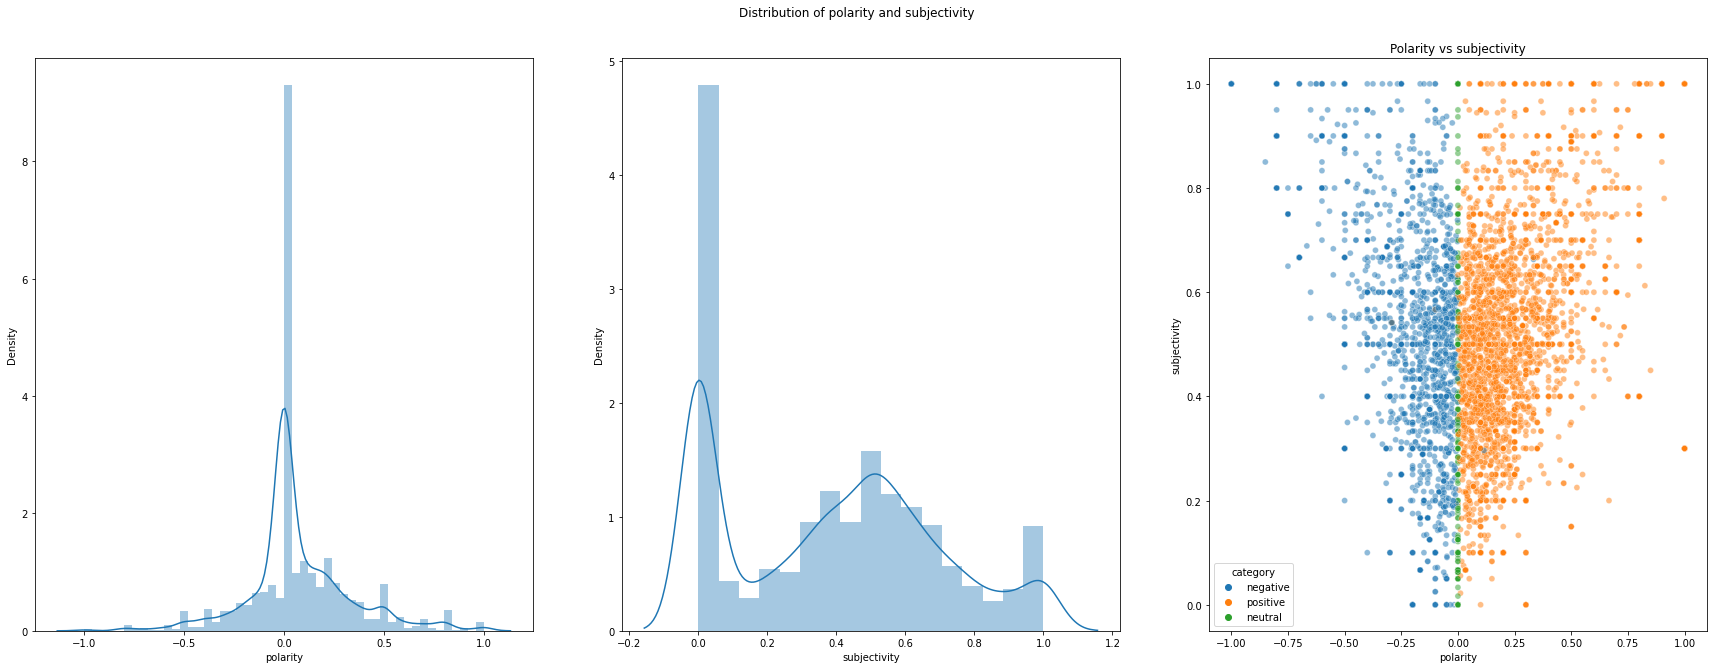

In [36]:
with warnings.catch_warnings():
  warnings.filterwarnings("ignore",category=DeprecationWarning)
  warnings.filterwarnings("ignore", category=FutureWarning)
  fig, ax = plt.subplots(1,3, figsize=(25,10))
  sns.distplot(df["polarity"], ax=ax[0])
  sns.distplot(df["subjectivity"], ax=ax[1])
  plt.suptitle("Distribution of polarity and subjectivity")
  sns.scatterplot(df["polarity"], df["subjectivity"], hue=df["category"], alpha=0.5, ax=ax[2])
  plt.title("Polarity vs subjectivity")
  fig.tight_layout(pad=5.0)
  plt.show()

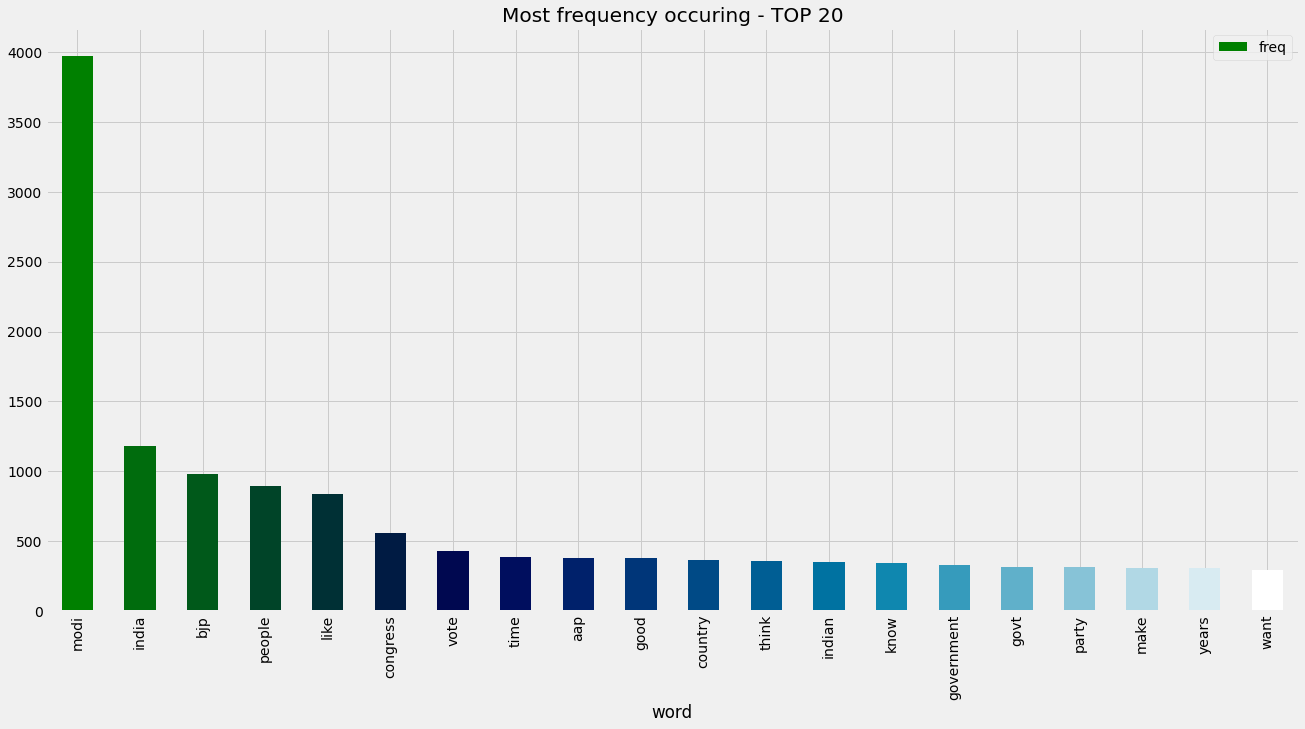

In [37]:
cv = CountVectorizer(stop_words="english")

words = cv.fit_transform(train["cleaned_text"])
sum_words = words.sum(axis=0) # sum of all words by text

words_freq =  [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]

words_freq = sorted(words_freq, key=lambda r:r[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns=["word", "freq"])

plt.style.use("fivethirtyeight")
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x="word", y="freq", kind="bar", color=color, figsize=(20, 10))
plt.title("Most frequency occuring - TOP 20")
plt.show()

In [38]:
from wordcloud import WordCloud

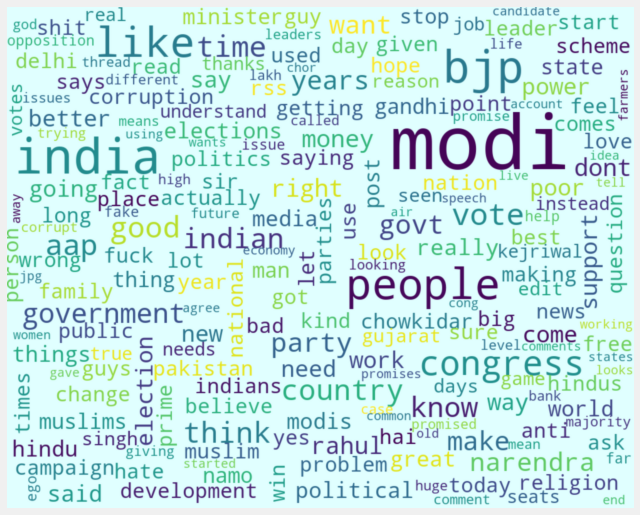

In [39]:
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       margin = 0,
                       max_words = 200,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "lightcyan").generate_from_frequencies(dict(words_freq))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

<b> LEMMATIZATION AND STEMMING PROCESS </b>

In [40]:
from tqdm import tqdm
import spacy
import networkx as nx
from spacy import displacy

In [41]:
nlp = spacy.load("en_core_web_sm")

In [42]:
train.loc[:,"text"].head()

3884     think need calculate the total drain the exche...
7063      lokpal will clear corruption out india and ev...
5126     took you hrs raju finally break silence this d...
5057     dear think you still dont get itnarendra modi ...
11666    she has purposely left behind von der leyen be...
Name: text, dtype: object

In [43]:
from multiprocess import (Pipe, Process, Pool, Manager)
import multiprocess
from functools import partial
from contextlib import contextmanager
import gensim
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:

def preprocess_tweets(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for tweets in df['cleaned_text']:
        words = [lem.lemmatize(w) for w in tweets.split() if len(w)>2]
        corpus.append(words)
    return corpus
corpus = preprocess_tweets(df)



In [45]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [46]:
## =============================================== LEMMATIZATION AND STEMMING PROCESS =======================================================
# Creating the LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.038*"modi" + 0.006*"one" + 0.005*"like" + 0.004*"time" + 0.004*"post" + 0.004*"india" + 0.004*"congress" + 0.004*"account" + 0.004*"back" + 0.003*"also"'),
 (1,
  '0.011*"modi" + 0.009*"people" + 0.006*"know" + 0.005*"would" + 0.005*"like" + 0.004*"time" + 0.004*"make" + 0.004*"india" + 0.004*"one" + 0.004*"hindu"'),
 (2,
  '0.016*"bjp" + 0.016*"modi" + 0.008*"aap" + 0.007*"india" + 0.007*"congress" + 0.006*"people" + 0.006*"party" + 0.006*"election" + 0.006*"like" + 0.005*"even"'),
 (3,
  '0.013*"modi" + 0.008*"bjp" + 0.006*"would" + 0.006*"people" + 0.005*"country" + 0.005*"congress" + 0.004*"think" + 0.004*"aap" + 0.004*"indian" + 0.004*"like"'),
 (4,
  '0.054*"modi" + 0.020*"india" + 0.009*"like" + 0.008*"people" + 0.008*"vote" + 0.006*"indian" + 0.005*"narendra" + 0.005*"year" + 0.005*"one" + 0.005*"bjp"')]

In [47]:
import gc

In [48]:
del corpus
gc.collect()

100

In [49]:
!pip install pyLDAvis

In [50]:
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [51]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.035134 -0.061727       1        1  30.480694
1     -0.100378  0.079210       2        1  20.350301
2      0.067250 -0.033449       3        1  17.795210
0     -0.034620 -0.046464       4        1  17.337654
4      0.102882  0.062430       5        1  14.036141, topic_info=            Term         Freq        Total Category  logprob  loglift
80          modi  3491.000000  3491.000000  Default  30.0000  30.0000
27           bjp   898.000000   898.000000  Default  29.0000  29.0000
168         vote   468.000000   468.000000  Default  28.0000  28.0000
32      congress   502.000000   502.000000  Default  27.0000  27.0000
306        rahul   221.000000   221.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
71         would    45.897255   388.949019   Topic5  -5.9319  -0.1735
574          see    40.990839   284.711495   Topic5  -6.0450   0.0254
80          modi    72.203621  3491.218175   Topic5  -5.4788  -1.9150
1436  government    40.460333   310.178150   Topic5  -6.0580  -0.0733
125         also    39.206337   306.387614   Topic5  -6.0895  -0.0925

[437 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
8157       4  0.917667  aadhaar
23         1  0.532620      aap
23         2  0.002992      aap
23         3  0.098744      aap
23         4  0.332139      aap
...      ...       ...      ...
72         4  0.252609     year
72         5  0.080731     year
1750       4  0.898921   yojana
1362       2  0.841496  zelalem
14122      3  0.915850    ‘alla

[960 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])

In [50]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.stem import (PorterStemmer, WordNetLemmatizer)

In [51]:
container = []
nlp = spacy.load("en_core_web_sm")

for text in train["cleaned_text"]:
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(w) for w in text.split() if len(w)>2]
    words = " ".join(words)
    container.append(words)

len(container)

7193

In [53]:
#===================================== PROCESSSING AND TFIDF ==================
label_encoder = preprocessing.LabelBinarizer()
tf_idf = TfidfVectorizer()
SEED = 10
X = tf_idf.fit_transform(container)
y = label_encoder.fit_transform(train.loc[:,"category"])

train_data, train_val , label_train, label_val =  train_test_split(X,  
                                                           y, 
                                                           test_size=TEST_SIZE/2, 
                                                           random_state=SEED, 
                                                           stratify=y)


lin_svc = LinearSVC(verbose=1, random_state=SEED)

one_vs_clf = OneVsRestClassifier(lin_svc, n_jobs=-1)
one_vs_clf.fit(train_data.toarray(), label_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=10, tol=0.0001,
                                        verbose=1),
                    n_jobs=-1)

In [54]:
y_pred_vs_clf = one_vs_clf.predict(train_val)


In [56]:
print(label_val[:5])
print("="*50)
print(label_train[:5])

[[0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]]
[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [57]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve

In [58]:
def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  try:
    y_true_names = lb_trained.inverse_transform(y_true)
    y_pred_names = lb_trained.inverse_transform(y_pred)
    print( classification_report(y_true_names, y_pred_names) )
    cm = confusion_matrix(y_true_names, y_pred_names)
    labels = ['negative', 'neutral', 'positive']
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    print(df_cm)
    print("OK...")
    
  except ValueError as err:
    print(err)
  
  sns.set(font_scale=1.2)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()


  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

    negative       0.51      0.74      0.60       323
     neutral       0.78      0.75      0.76       487
    positive       0.88      0.71      0.79       629

    accuracy                           0.73      1439
   macro avg       0.72      0.73      0.72      1439
weighted avg       0.76      0.73      0.74      1439

          negative  neutral  positive
negative       238       44        41
neutral        104      365        18
positive       124       60       445
OK...


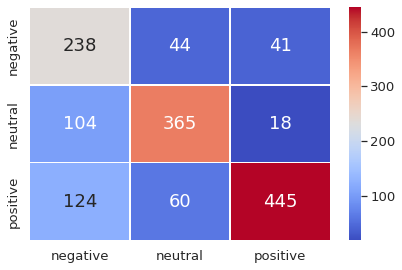

negative 0.6884092346616065
neutral 0.8180206374130761
positive 0.8220102455396572


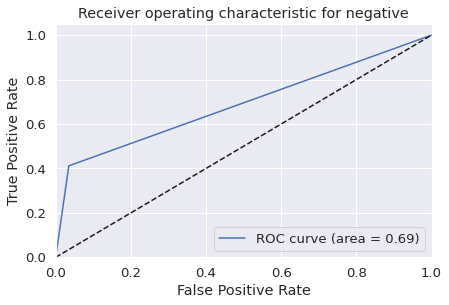

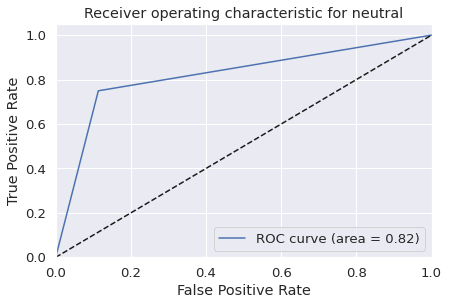

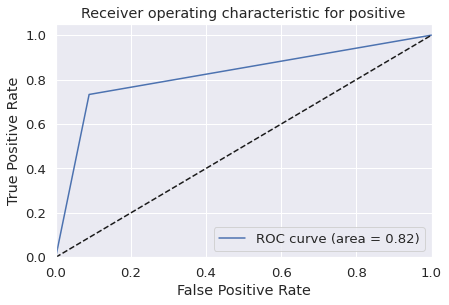

In [60]:
y_pred_vs_clf = one_vs_clf.predict(train_val)

show_eval(label_val, y_pred_vs_clf, label_encoder, one_vs_clf)

### FURTHERMORE 